In [1]:
import numpy as np
import pandas as pd
import random
from numpy.random import rand
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

In [2]:
a = 0
b = np.pi/4
L, R = 0, 1
def fi(x): 
    return np.tan(x)
def X():
    return a + (b-a) * rand()
def Y(x):
    return fi(x)

## Lab 1

In [3]:
n = 30
def make_samples(n):
    x_sample = np.array([X() for i in range(n)])
    y_sample = Y(x_sample)
    y_sample.sort()
    return x_sample, y_sample

### params of continious uniform distribution X

In [4]:
def uniform_mean(a, b):
    return (a + b) / 2

def uniform_std(a, b):
    return (b - a)**2 / 12

def M_uni():
    return uniform_mean(a, b)

def D_uni():
    return uniform_std(a, b)

x_mean = M_uni()
x_std = D_uni()
print(f'theoretical mean of X: {round(x_mean, 4)}')
print(f'theoretical std of X: {round(x_std, 4)}')

theoretical mean of X: 0.3927
theoretical std of X: 0.0514


### theoretical distribution function, density function

In [5]:
a_Y = Y(a)
b_Y = Y(b)
print(f'New interval: {(a_Y, b_Y)}')


def F(y):
    if y < a_Y: return 0
    if a_Y <= y < b_Y: return 4 / np.pi * np.arctan(y)
    if y > b_Y: return 1

    
def f(y):
    if a_Y < y < b_Y: return 4 / (np.pi * (1 + y**2))
    return 0

New interval: (0.0, 0.9999999999999999)


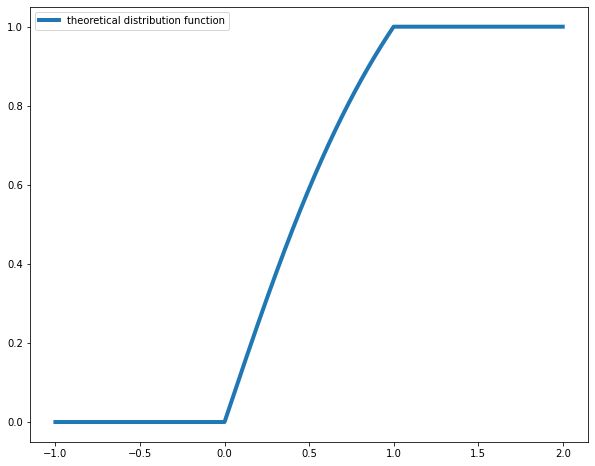

In [6]:
dots_count = 10**3
x_dots = np.linspace(a_Y-1, b_Y+1, dots_count)
y_dots = [F(x) for x in x_dots]
plt.rcParams["figure.figsize"] = (10, 8)
plt.plot(x_dots, y_dots, linewidth=4, label='theoretical distribution function');
plt.legend();

### imperical distribution function

#### get sample

In [7]:
sample = make_samples(n)[1]

In [8]:
def generate_samples(n, sample):
    n = len(sample)
    sample = list(sample)
    y_sample = [-1, sample[0]] + sample + [1, 2]
    emperic = [0, 0] + list([(i)/n for i in range(n)]) + [1, 1]
    return y_sample, emperic

generated = generate_samples(n, sample)

print(f'imperical mean = {np.mean(generated[0])}')
print(f'imperical std = {np.std(generated[0])}')

def update(N=n):
    global generated, sample
    sample = make_samples(n)[1]
    generated = generate_samples(N, sample)

imperical mean = 0.45006493808549414
imperical std = 0.4711079498901468


In [9]:
data = pd.DataFrame(data={'x':generated[0], 'y':generated[1]})
data.head()

,x,y
0,-1.000000,0.000000
1,0.027035,0.000000
2,0.027035,0.000000
3,0.054867,0.033333
4,0.063827,0.066667


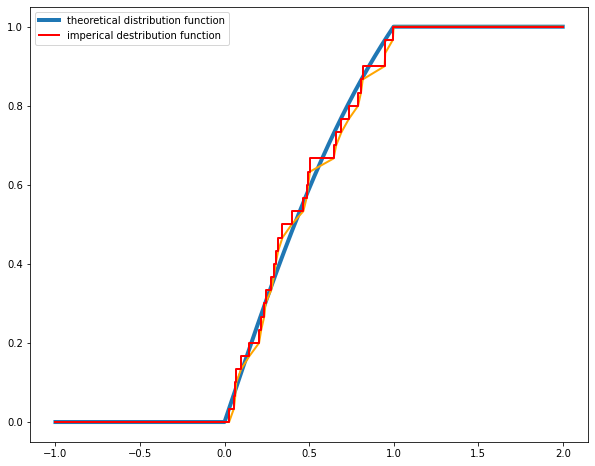

In [10]:
plt.rcParams["figure.figsize"] = (10, 8)
plt.plot(x_dots, y_dots, linewidth=4, label='theoretical distribution function');
plt.plot(generated[0], generated[1], linewidth=2, color='orange')
plt.step(generated[0], generated[1], linewidth=2, color='red', label='imperical destribution function')
plt.legend();

## Lab 2

## building histograms

In [11]:
def build_histogram(sample, equidistand=True, bins=None):
    k = bins
    n = len(sample)
    M = None
    if k is None:
        if n <= 100:
            k = int(np.sqrt(n))
        else:
            k = 1 + int(3.322 * np.log10(n))

    hist = pd.DataFrame(columns=['Ai', 'Bi', 'v', 'hi', 'fi', 'mid', 'nums'])
    x_1, x_n = sample[0] - 0.00001, sample[-1] + 0.00001
    h = (x_n - x_1) / k

    def get_new_A_equdist(i):
        return x_1 + (i - 1) * h

    def get_new_A_not_equdist(i, prev_segment):

        if i == 1:
            return x_1
        left_border, right_border = prev_segment, None
        segment = intervals / k
        if i == 2:
            left_border = 0
        right_border = left_border + segment
        diff_part = right_border - int(right_border)
        index_for_B = int(right_border)
        B = (sample[index_for_B + 1] - sample[index_for_B]) * diff_part + sample[index_for_B]

        return B, right_border

    if equidistand:


        iter = 0
        saved_for_next = 0
        for i in range(1, k + 1):
            A = get_new_A_equdist(i)
            B = get_new_A_equdist(i + 1)
            mid = (B + A) / 2

            v = saved_for_next  # frequency
            saved_for_next = 0
            nums = []
            while (iter < n) and (sample[iter] <= B):
                nums.append(sample[iter])
                if sample[iter] == B:
                    v += 0.5
                    saved_for_next += 0.5
                else:
                    v += 1
                iter += 1

            if iter == n-1:
                v += saved_for_next

            fi = v / (n * h)
            hist.loc[i] = [A, B, v, h, fi, mid, nums]

        return hist

    else:
        if k > n - 1:
            if n <= 100:
                k = int(np.sqrt(n))
            else:
                k = 1 + int(3.322 * np.log10(n))
        intervals = n-1
        segments = intervals / k
        prev_segment = None
        A, B = None, None
        iter = 0
        for i in range(1, k + 1):
            if i == 1:
                A = get_new_A_not_equdist(1, None)
            else:
                A = B
            if i == k:
                B = x_n
            else:
                B, prev_segment = get_new_A_not_equdist(i+1, prev_segment)

            h = B - A
            mid = (A + B) / 2
            v = 0
            nums = []
            while (iter < n) and (sample[iter] < B):
                nums.append(sample[iter])
                v += 1
                iter += 1

            fi = (v * (x_n-x_1)) / (n * h)
            hist.loc[i] = [A, B, v, h, fi, mid, nums]

        return hist

In [12]:
def draw_hist(hist_data):
    x = []
    y = []
    for i in range(1, hist_data.shape[0]+1):
        x.append(hist_data.loc[i, 'Ai'])
        y.append(0)
        x.append(hist_data.loc[i, 'Ai'])
        y.append(hist_data.loc[i, 'fi'])
        x.append(hist_data.loc[i, 'Bi'])
        y.append(hist_data.loc[i, 'fi'])
    x.append(hist_data.loc[hist_data.shape[0], 'Bi'])
    y.append(0)
    return x, y


def get_hist_points(hist_data):
    x, y = draw_hist(hist_data)
    return x, y

def get_polygon_points(hist_data):
    x = []
    y = []
    for i in range(1, hist_data.shape[0]+1):
        x.append(hist_data.loc[i, 'mid'])
        y.append(hist_data.loc[i, 'fi'])
    return x, y

## histogram and polygon draw functions

In [13]:
def draw_histogram_plot(x, y, label_hist='histogram'):
    plt.plot(x, y, label=label_hist)
    plt.show()
def draw_polygon_plot(x, y, label_poly='polygon'):
    plt.plot(x, y, label = label_poly)
    plt.show()

## Equal intervals histogram & polygon

In [14]:
hist_data_equal = build_histogram(sample)
hist_data_equal

,Ai,Bi,v,hi,fi,mid,nums
1,0.027025,0.220708,8,0.193683,1.376822,0.123867,"[0.027035217698517168, 0.05486697361326386, 0...."
2,0.220708,0.414391,8,0.193683,1.376822,0.317549,"[0.23484871122122644, 0.24249710833802182, 0.2..."
3,0.414391,0.608073,4,0.193683,0.688411,0.511232,"[0.4660771348716926, 0.48530791289402375, 0.49..."
4,0.608073,0.801756,5,0.193683,0.860514,0.704915,"[0.6449111556212627, 0.6602104912410649, 0.691..."
5,0.801756,0.995439,5,0.193683,0.860514,0.898598,"[0.8070184581018308, 0.8175288465963338, 0.946..."


### drawing equal intervals histogram and polygon

#### get points 

In [15]:
x_hist_equal, y_hist_equal = get_hist_points(hist_data_equal)
x_poly_equal, y_poly_equal = get_polygon_points(hist_data_equal)

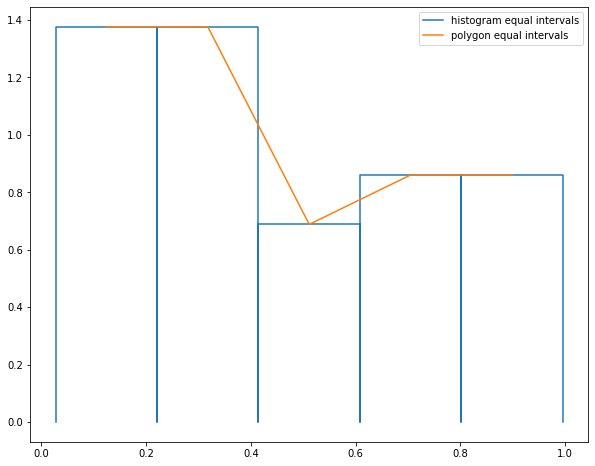

In [16]:
plt.plot(x_hist_equal, y_hist_equal, label='histogram equal intervals')
plt.plot(x_poly_equal, y_poly_equal, label ='polygon equal intervals')
plt.legend()

## Equal probabilities histogram & polygon

In [17]:
hist_data_prob = build_histogram(sample, equidistand=False)
x_hist_prob, y_hist_prob = get_hist_points(hist_data_prob)
x_poly_prob, y_poly_prob = get_polygon_points(hist_data_prob)

In [18]:
hist_data_prob

,Ai,Bi,v,hi,fi,mid,nums
1,0.027025,0.192709,6,0.165684,1.168987,0.109867,"[0.027035217698517168, 0.05486697361326386, 0...."
2,0.192709,0.297888,6,0.105179,1.841459,0.245299,"[0.20421960866795075, 0.21691523377696448, 0.2..."
3,0.297888,0.489091,6,0.191203,1.012969,0.393490,"[0.3022092853117855, 0.3173798189461365, 0.342..."
4,0.489091,0.746168,6,0.257077,0.753405,0.617630,"[0.4947666967096307, 0.5050725646841162, 0.644..."
5,0.746168,0.995439,6,0.249271,0.776997,0.870803,"[0.7898683766727315, 0.8070184581018308, 0.817..."


### drawing equal probability histogram and polygon

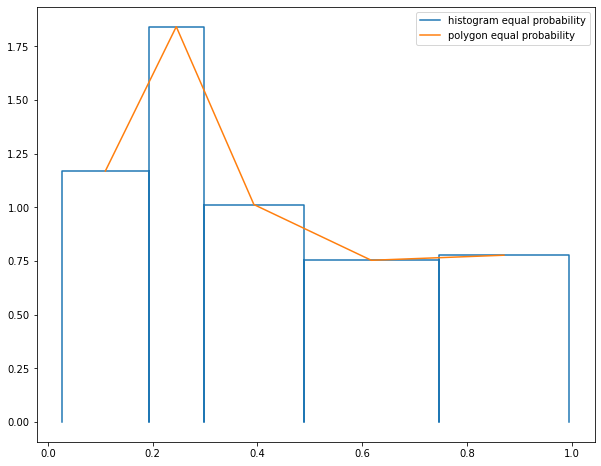

In [19]:
plt.plot(x_hist_prob, y_hist_prob, label='histogram equal probability')
plt.plot(x_poly_prob, y_poly_prob, label ='polygon equal probability')
plt.legend()

### comparing intervals and probability histograms

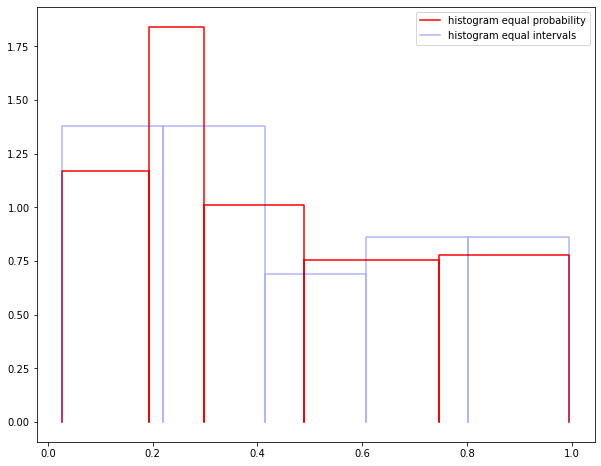

In [20]:
plt.plot(x_hist_prob, y_hist_prob, color='red', label='histogram equal probability')
# plt.plot(x_poly_prob, y_poly_prob, color='red', label ='polygon equal probability')
plt.plot(x_hist_equal, y_hist_equal, color='blue', label='histogram equal intervals', alpha=.3)
# plt.plot(x_poly_equal, y_poly_equal, color='blue', label ='polygon equal intervals', alpha=.3)

plt.legend()

## group data for distribution function intervals

In [21]:
def get_gropued_data(hist_data):
    sample = list(hist_data['Ai']) + [hist_data.iloc[-1, 1]]
    n = len(sample)
    y_sample = [-1, sample[0]] + sample + [1, 2]
    emperic = [0, 0] + list([(i)/n for i in range(n)]) + [1, 1]
    return y_sample, emperic

In [22]:
grouped_data_equal = get_gropued_data(hist_data_equal)

In [23]:
grouped_df_equal = pd.DataFrame(data={'x':grouped_data_equal[0], 'y':grouped_data_equal[1]})
grouped_df_equal.head()

,x,y
0,-1.000000,0.000000
1,0.027025,0.000000
2,0.027025,0.000000
3,0.220708,0.166667
4,0.414391,0.333333


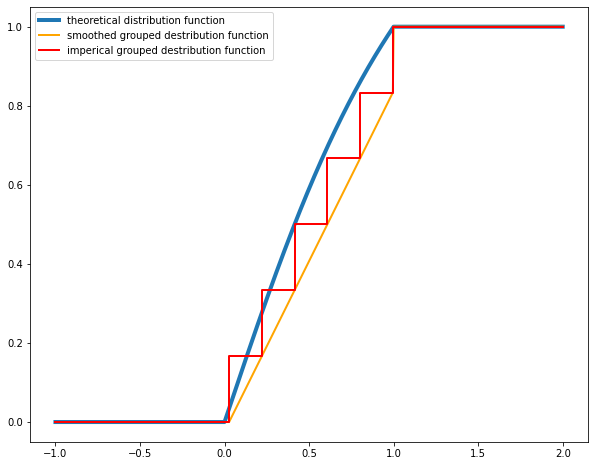

In [24]:
plt.rcParams["figure.figsize"] = (10, 8)
plt.plot(x_dots, y_dots, linewidth=4, label='theoretical distribution function');
plt.plot(grouped_data_equal[0], grouped_data_equal[1], linewidth=2, color='orange', label='smoothed grouped destribution function')
plt.step(grouped_data_equal[0], grouped_data_equal[1], linewidth=2, color='red', label='imperical grouped destribution function')
plt.legend();

## group data for distribution function probability

In [25]:
grouped_data_prob = get_gropued_data(hist_data_prob)

In [26]:
grouped_df_prob = pd.DataFrame(data={'x':grouped_data_prob[0], 'y':grouped_data_prob[1]})
grouped_df_prob.head()

,x,y
0,-1.000000,0.000000
1,0.027025,0.000000
2,0.027025,0.000000
3,0.192709,0.166667
4,0.297888,0.333333


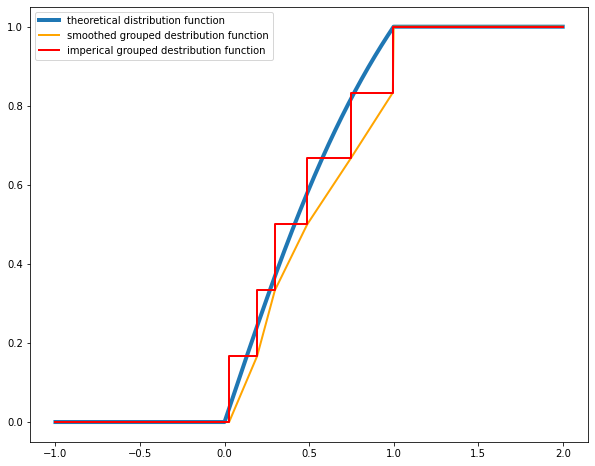

In [27]:
plt.rcParams["figure.figsize"] = (10, 8)
plt.plot(x_dots, y_dots, linewidth=4, label='theoretical distribution function');
plt.plot(grouped_data_prob[0], grouped_data_prob[1], linewidth=2, color='orange', label='smoothed grouped destribution function')
plt.step(grouped_data_prob[0], grouped_data_prob[1], linewidth=2, color='red', label='imperical grouped destribution function')
plt.legend();

### probabilty and intervals distribution functions

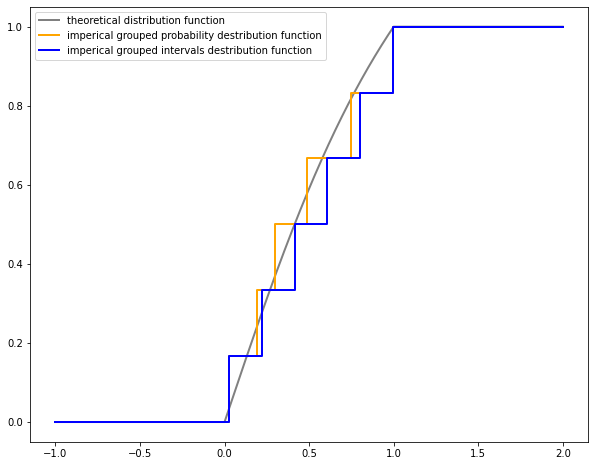

In [28]:
plt.plot(x_dots, y_dots, linewidth=2, color='gray', label='theoretical distribution function');
plt.step(grouped_data_prob[0], grouped_data_prob[1], linewidth=2, color='orange', label='imperical grouped probability destribution function')
# plt.plot(grouped_data_prob[0], grouped_data_prob[1], linewidth=2, color='orange', label='smoothed grouped destribution function')
plt.step(grouped_data_equal[0], grouped_data_equal[1], linewidth=2, color='blue', label='imperical grouped intervals destribution function')
# plt.plot(grouped_data_equal[0], grouped_data_equal[1], linewidth=2, color='blue', label='smoothed grouped destribution function')
plt.legend()

## Density function  

In [29]:
def get_plot_dens_data(sample_x, sample_y):
#     new_x = [a_Y] + sample_x + [b_Y]
    new_x = [a_Y] + [sample_x[0]-0.001] + sample_x + [sample_x[-1]+0.001] + [b_Y]
#     new_y = [0] + sample_y + [0]
    new_y = [0] + [sample_y[0]-0.001] + sample_y +  [sample_y[-1] + 0.001] + [0]
    return new_x, new_y
    return sample_x, sample_y

### Density funtcion for equal intervals

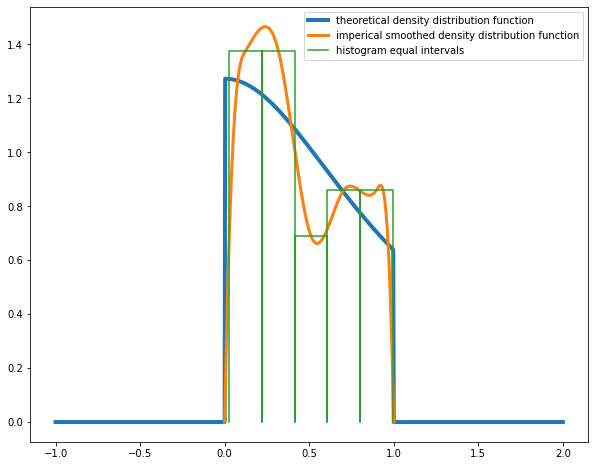

In [30]:
# theoretical
dots_count = 10**3
x_dots_dens = np.linspace(a_Y-1, b_Y+1, dots_count)
y_dots_dens = [f(x) for x in x_dots_dens]
plt.rcParams["figure.figsize"] = (10, 8)
plt.plot(x_dots_dens, y_dots_dens, linewidth=4, label='theoretical density distribution function');


# imperical
x_dens_prepared, y_dens_prepared = get_plot_dens_data(x_poly_equal, y_poly_equal)
x_den, y_den = np.array(x_dens_prepared), np.array(y_dens_prepared)
x_den_new = np.linspace(x_den.min(), x_den.max(), 200)
spline = make_interp_spline(x_den, y_den, k=3)
y_den_smooth = spline(x_den_new)
plt.plot([a_Y-0.001] + list(x_den_new) + [b_Y+0.001],[0] + list(y_den_smooth) + [0], linewidth=3, label = 'imperical smoothed density distribution function')
# plt.plot(x_dens_prepared,y_dens_prepared, label='not smoothed')

plt.plot(x_hist_equal, y_hist_equal, label='histogram equal intervals')

plt.legend()


### Density funtcion for equal probabilities

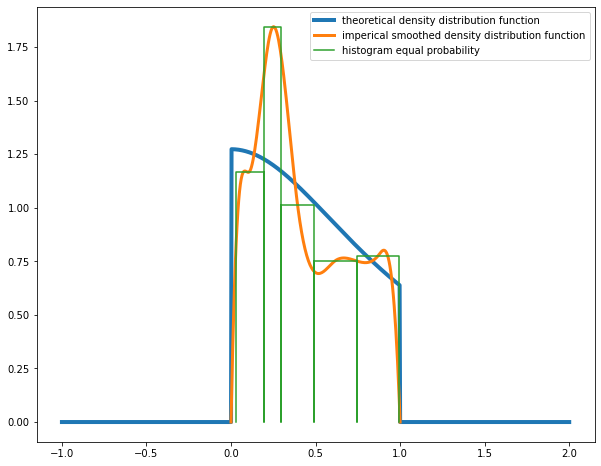

In [31]:
dots_count = 10**3
x_dots_dens = np.linspace(a_Y-1, b_Y+1, dots_count)
y_dots_dens = [f(x) for x in x_dots_dens]
plt.rcParams["figure.figsize"] = (10, 8)
plt.plot(x_dots_dens, y_dots_dens, linewidth=4, label='theoretical density distribution function');

x_dens_prepared_prob, y_dens_prepared_prob = get_plot_dens_data(x_poly_prob, y_poly_prob)
x_den_prob, y_den_prob = np.array(x_dens_prepared_prob), np.array(y_dens_prepared_prob)
x_den_new_prob = np.linspace(x_den_prob.min(), x_den_prob.max(), 200)
spline_prob = make_interp_spline(x_den_prob, y_den_prob, k=3)
y_den_smooth_prob = spline_prob(x_den_new_prob)
plt.plot(list(x_den_new_prob),list(y_den_smooth_prob), linewidth=3, label = 'imperical smoothed density distribution function')


plt.plot(x_hist_prob, y_hist_prob, label='histogram equal probability')
# plt.plot(x_poly_prob, y_poly_prob, label ='polygon equal probability')

plt.legend();

# Lab 3

In [32]:
n_pearson = 200
n_kolm = 30
n_mises = 50

samp = make_samples(n_pearson)[1]
sample_pearson = samp
sample_kolm = samp
sample_mises = samp

## Pearson test

In [33]:
from scipy import stats

In [34]:
def get_chi2(hist_data):
    n = hist_data['v'].sum()
    hi_quad = 0
    for i in range(hist_data.shape[0]):
        p_emperic = hist_data.iloc[i, 2] / n
        A, B = hist_data.iloc[i, 0], hist_data.iloc[i, 1]
        p_theor = F(B) - F(A)
        hi_quad += n * (((p_emperic - p_theor)**2) / p_theor)
    return hi_quad


def check_pearson_hyp(sample, alpha):
    hist_data = build_histogram(sample, equidistand=False)
    df = hist_data.shape[0] - 1
    chi2 = get_chi2(hist_data)
    chi2_critic = stats.chi2.ppf(alpha, df)

    print(f'Pearson\'s chi-squared test with alpha={(1-alpha):.2} \
          \n\tchi2 = {chi2:.2f} \
          \n\tchi2_critical = {chi2_critic:.2f} |({(alpha, df)})\
          \n\tverdict: {chi2 < chi2_critic}')
    return hist_data, chi2, chi2_critic, df

In [35]:
n_pearson = 50
sample_p = sample_pearson

histogram_p, chi2, chi2_critic, df = check_pearson_hyp(sample_p, 0.001);

check_pearson_hyp(sample_p, 0.5);
check_pearson_hyp(sample_p, 0.7);
check_pearson_hyp(sample_p, 0.8);
check_pearson_hyp(sample_p, 0.9);
check_pearson_hyp(sample_p, 0.95);
check_pearson_hyp(sample_p, 0.99);
histogram_p

Pearson's chi-squared test with alpha=1.0           
	chi2 = 9.68           
	chi2_critical = 0.60 |((0.001, 7))          
	verdict: False
Pearson's chi-squared test with alpha=0.5           
	chi2 = 9.68           
	chi2_critical = 6.35 |((0.5, 7))          
	verdict: False
Pearson's chi-squared test with alpha=0.3           
	chi2 = 9.68           
	chi2_critical = 8.38 |((0.7, 7))          
	verdict: False
Pearson's chi-squared test with alpha=0.2           
	chi2 = 9.68           
	chi2_critical = 9.80 |((0.8, 7))          
	verdict: True
Pearson's chi-squared test with alpha=0.1           
	chi2 = 9.68           
	chi2_critical = 12.02 |((0.9, 7))          
	verdict: True
Pearson's chi-squared test with alpha=0.05           
	chi2 = 9.68           
	chi2_critical = 14.07 |((0.95, 7))          
	verdict: True
Pearson's chi-squared test with alpha=0.01           
	chi2 = 9.68           
	chi2_critical = 18.48 |((0.99, 7))          
	verdict: True


,Ai,Bi,v,hi,fi,mid,nums
1,0.000247,0.061941,25,0.061694,1.957293,0.031094,"[0.00025693430902447024, 0.003972097837415694,..."
2,0.061941,0.176968,25,0.115028,1.049772,0.119455,"[0.06237857289755751, 0.06744250806853082, 0.0..."
3,0.176968,0.257109,25,0.080140,1.506768,0.217039,"[0.17779801360678338, 0.17880305851061867, 0.1..."
4,0.257109,0.396768,25,0.139659,0.864627,0.326938,"[0.26119609069143596, 0.26177291957960164, 0.2..."
5,0.396768,0.522513,25,0.125746,0.960294,0.459640,"[0.3978579593626595, 0.3993246783563078, 0.400..."
6,0.522513,0.656673,25,0.134159,0.900070,0.589593,"[0.5232232961673728, 0.5238188768008777, 0.526..."
7,0.656673,0.788033,25,0.131361,0.919247,0.722353,"[0.6651096842310956, 0.6654761584432904, 0.685..."
8,0.788033,0.966270,25,0.178237,0.677487,0.877151,"[0.7915825684133779, 0.8020951566762909, 0.810..."


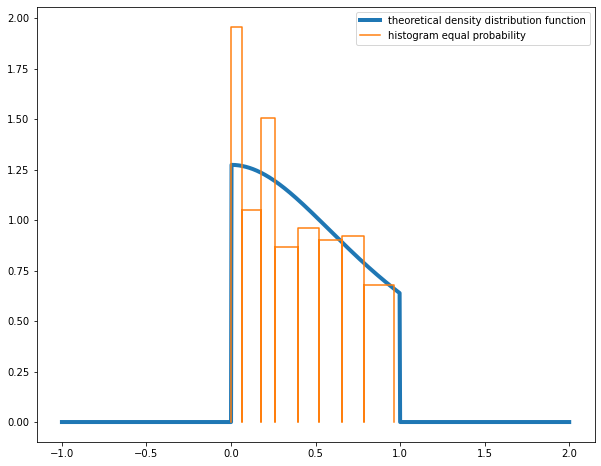

In [36]:
dots_count = 10**3
x_dots_dens = np.linspace(a_Y-1, b_Y+1, dots_count)
y_dots_dens = [f(x) for x in x_dots_dens]
plt.rcParams["figure.figsize"] = (10, 8)
plt.plot(x_dots_dens, y_dots_dens, linewidth=4, label='theoretical density distribution function');


x_hist_prob, y_hist_prob = get_hist_points(histogram_p)
x_poly_prob, y_poly_prob = get_polygon_points(histogram_p)
x_dens_prepared_prob, y_dens_prepared_prob = get_plot_dens_data(x_poly_prob, y_poly_prob)
x_den_prob, y_den_prob = np.array(x_dens_prepared_prob), np.array(y_dens_prepared_prob)
x_den_new_prob = np.linspace(x_den_prob.min(), x_den_prob.max(), 200)
spline_prob = make_interp_spline(x_den_prob, y_den_prob, k=3)
y_den_smooth_prob = spline_prob(x_den_new_prob)
# plt.plot(list(x_den_new_prob),list(y_den_smooth_prob), linewidth=3, label = 'imperical smoothed density distribution function')


plt.plot(x_hist_prob, y_hist_prob, label='histogram equal probability')
# plt.plot(x_poly_prob, y_poly_prob, label ='polygon equal probability')

plt.legend();

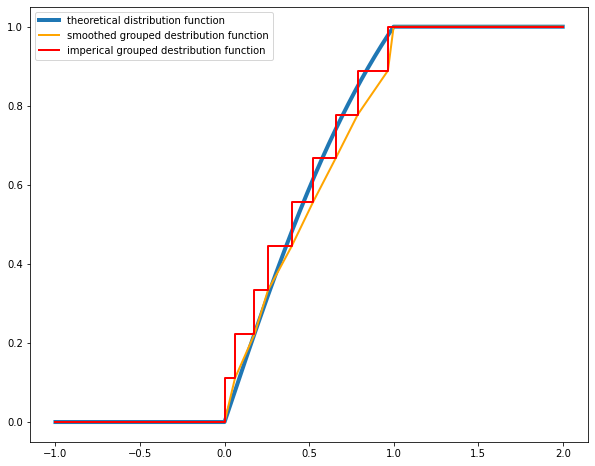

In [37]:
grouped_data_prob = get_gropued_data(histogram_p)
plt.rcParams["figure.figsize"] = (10, 8)
plt.plot(x_dots, y_dots, linewidth=4, label='theoretical distribution function');
plt.plot(grouped_data_prob[0], grouped_data_prob[1], linewidth=2, color='orange', label='smoothed grouped destribution function')
plt.step(grouped_data_prob[0], grouped_data_prob[1], linewidth=2, color='red', label='imperical grouped destribution function')
plt.legend();
grouped_df_prob = pd.DataFrame(data={'x':grouped_data_prob[0], 'y':grouped_data_prob[1]})

In [38]:
chi2_critic = stats.chi2.ppf(0.99, 4)
chi2_critic

13.276704135987622

## Kolmogorov test

In [39]:
def get_kolmogorov_value(sample):
    n = len(sample)
    emperic_F = [i/n for i in range(n)]
    d = 0
    max_delta_x = 0
    for i in range(n):
#         d = max(d, abs(emperic_F[i], F(sample[i])))
        saved_d = d
        d = max(d, max(abs(i/n - F(sample[i])), abs((i+1)/n - F(sample[i]))))
        if saved_d != d:
            max_delta_x = sample[i], (i/n + (i+1)/n) / 2
    K = d * np.sqrt(n) + 1/(6*np.sqrt(n))
    return K, max_delta_x


def check_kolmogorov_hyp(sample, alpha):
    K, max_delta_x = get_kolmogorov_value(sample)
    K_critical = stats.kstwobign.ppf(alpha)
    print(f'Kolmogorov test with alpha = {(1-alpha):.2f}\n\t\
            K = {K:.4f}\n\t\
            K_critical = {K_critical:.4f} | {alpha}\n\t\
            verdict: {K < K_critical}')
    return max_delta_x

In [40]:
n_kolm = 30
sample_k = sample_kolm

max_delta_x = check_kolmogorov_hyp(sample_k, 0.5);
check_kolmogorov_hyp(sample_k, 0.6);
check_kolmogorov_hyp(sample_k, 0.7);
check_kolmogorov_hyp(sample_k, 0.8);
check_kolmogorov_hyp(sample_k, 0.9);
check_kolmogorov_hyp(sample_k, 0.95);
check_kolmogorov_hyp(sample_k, 0.99);

Kolmogorov test with alpha = 0.50
	            K = 1.0738
	            K_critical = 0.8276 | 0.5
	            verdict: False
Kolmogorov test with alpha = 0.40
	            K = 1.0738
	            K_critical = 0.8948 | 0.6
	            verdict: False
Kolmogorov test with alpha = 0.30
	            K = 1.0738
	            K_critical = 0.9731 | 0.7
	            verdict: False
Kolmogorov test with alpha = 0.20
	            K = 1.0738
	            K_critical = 1.0727 | 0.8
	            verdict: False
Kolmogorov test with alpha = 0.10
	            K = 1.0738
	            K_critical = 1.2238 | 0.9
	            verdict: True
Kolmogorov test with alpha = 0.05
	            K = 1.0738
	            K_critical = 1.3581 | 0.95
	            verdict: True
Kolmogorov test with alpha = 0.01
	            K = 1.0738
	            K_critical = 1.6276 | 0.99
	            verdict: True


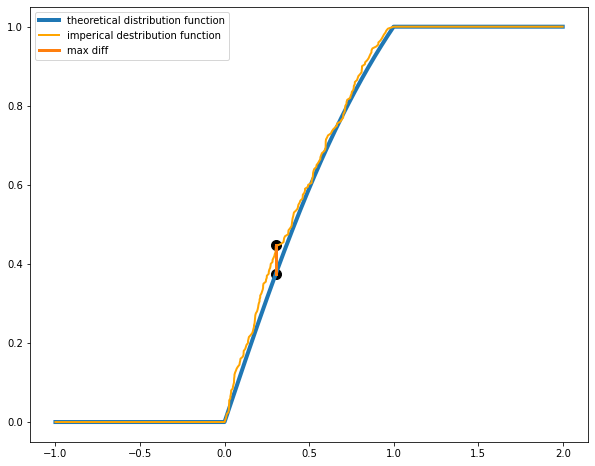

In [41]:
kolm_data = generate_samples(n_kolm, sample_k)


plt.rcParams["figure.figsize"] = (10, 8)
plt.plot(x_dots, y_dots, linewidth=4, label='theoretical distribution function');
plt.plot(kolm_data[0], kolm_data[1], linewidth=2, color='orange',  label='imperical destribution function')
# plt.step(kolm_data[0], kolm_data[1], linewidth=2, color='red', label='imperical destribution function')
plt.scatter(max_delta_x[0], max_delta_x[1], s=100, color='black')
plt.scatter(max_delta_x[0], F(max_delta_x[0]), s=100, color='black')
plt.plot([max_delta_x[0], max_delta_x[0]], [max_delta_x[1], F(max_delta_x[0])], linewidth=3, label='max diff')
plt.legend();


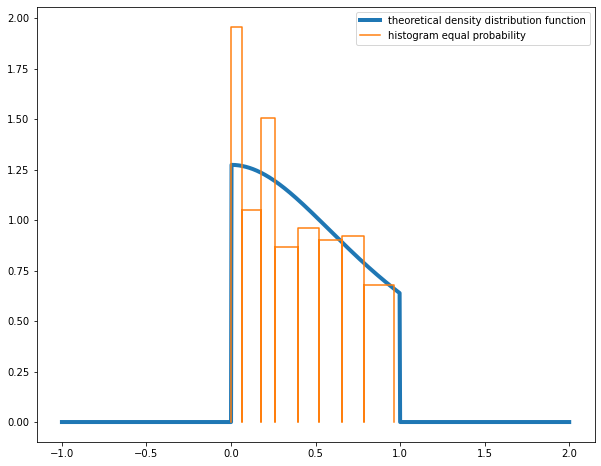

In [42]:
hist_k = build_histogram(sample_k, equidistand=False)


dots_count = 10**3
x_dots_dens = np.linspace(a_Y-1, b_Y+1, dots_count)
y_dots_dens = [f(x) for x in x_dots_dens]
plt.rcParams["figure.figsize"] = (10, 8)
plt.plot(x_dots_dens, y_dots_dens, linewidth=4, label='theoretical density distribution function');


x_hist_prob, y_hist_prob = get_hist_points(hist_k)
x_poly_prob, y_poly_prob = get_polygon_points(hist_k)
x_dens_prepared_prob, y_dens_prepared_prob = get_plot_dens_data(x_poly_prob, y_poly_prob)
x_den_prob, y_den_prob = np.array(x_dens_prepared_prob), np.array(y_dens_prepared_prob)
x_den_new_prob = np.linspace(x_den_prob.min(), x_den_prob.max(), 200)
spline_prob = make_interp_spline(x_den_prob, y_den_prob, k=3)
y_den_smooth_prob = spline_prob(x_den_new_prob)
# plt.plot(list(x_den_new_prob),list(y_den_smooth_prob), linewidth=3, label = 'imperical smoothed density distribution function')


plt.plot(x_hist_prob, y_hist_prob, label='histogram equal probability')
# plt.plot(x_poly_prob, y_poly_prob, label ='polygon equal probability')

plt.legend();

## Mises criterion

In [43]:
def get_mises_value(sample):
    n = len(sample)
    w = 1 / (12 * n)
    for i in range(0, n):
        w += (F(sample[i]) - ((i - 0.5) / n)) ** 2
        
    return w

def get_mises_critic(alpha):
    if alpha == 0.9:
        return 0.3473
    if alpha == 0.95:
        return 0.4614
    if alpha == 0.99:
        return 0.7435
    raise ValueError("not such alpha in table")
    
def check_mises_hyp(sample, alpha):
    w = get_mises_value(sample)
    w_critical = get_mises_critic(alpha)
    print(f'Mises test with alpha = {(1-alpha):.2f}\n\t\
            w = {w:.4f}\n\t\
            w_critical = {w_critical:.4f} | {alpha}\n\t\
            verdict: {w < w_critical}')

In [44]:
n_mises = 50
sample_mises = sample_mises


check_mises_hyp(sample_mises, 0.9)
check_mises_hyp(sample_mises, 0.95)
check_mises_hyp(sample_mises, 0.99)


Mises test with alpha = 0.10
	            w = 0.1615
	            w_critical = 0.3473 | 0.9
	            verdict: True
Mises test with alpha = 0.05
	            w = 0.1615
	            w_critical = 0.4614 | 0.95
	            verdict: True
Mises test with alpha = 0.01
	            w = 0.1615
	            w_critical = 0.7435 | 0.99
	            verdict: True


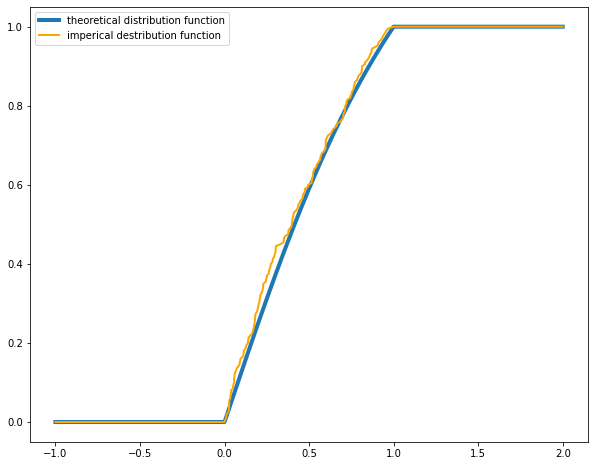

In [45]:
mises_data = generate_samples(n_mises, sample_mises)


plt.rcParams["figure.figsize"] = (10, 8)
plt.plot(x_dots, y_dots, linewidth=4, label='theoretical distribution function');
plt.plot(mises_data[0], mises_data[1], linewidth=2, color='orange',  label='imperical destribution function')
# plt.step(kolm_data[0], kolm_data[1], linewidth=2, color='red', label='imperical destribution function')


plt.legend();

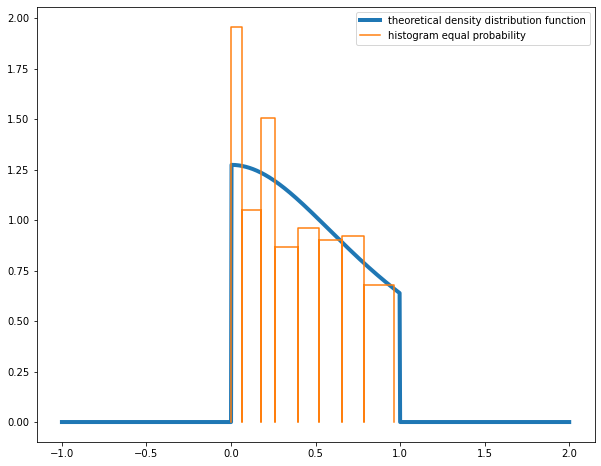

In [46]:
hist_mises = build_histogram(sample_mises, equidistand=False)


dots_count = 10**3
x_dots_dens = np.linspace(a_Y-1, b_Y+1, dots_count)
y_dots_dens = [f(x) for x in x_dots_dens]
plt.rcParams["figure.figsize"] = (10, 8)
plt.plot(x_dots_dens, y_dots_dens, linewidth=4, label='theoretical density distribution function');


x_hist_prob, y_hist_prob = get_hist_points(hist_mises)
x_poly_prob, y_poly_prob = get_polygon_points(hist_mises)
x_dens_prepared_prob, y_dens_prepared_prob = get_plot_dens_data(x_poly_prob, y_poly_prob)
x_den_prob, y_den_prob = np.array(x_dens_prepared_prob), np.array(y_dens_prepared_prob)
x_den_new_prob = np.linspace(x_den_prob.min(), x_den_prob.max(), 200)
spline_prob = make_interp_spline(x_den_prob, y_den_prob, k=3)
y_den_smooth_prob = spline_prob(x_den_new_prob)
# plt.plot(list(x_den_new_prob),list(y_den_smooth_prob), linewidth=3, label = 'imperical smoothed density distribution function')


plt.plot(x_hist_prob, y_hist_prob, label='histogram equal probability')
# plt.plot(x_poly_prob, y_poly_prob, label ='polygon equal probability')

plt.legend();

# LAB 4